## Connect to Google Drive
Mount Google Drive so datasets and scripts stored there can be accessed in Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Install and Import Packages
Install **Ultralytics YOLO** and import required Python packages.  
We also add the custom `src/` directory to `sys.path` so we can directly import local modules (e.g., `preprocessing.py`).


In [ ]:
!pip install ultralytics
import sys
sys.path.append("/content/drive/MyDrive/ML_projects/object-detection/src/")
import os
import os
import matplotlib.pyplot as plt
from PIL import Image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.9 MB/s eta 0:00:00


## Visulaize sample label file

In [ ]:

# Path to your labels folder
label_dir = '/content/drive/MyDrive/Datasets/DOTA/train/labels'

# List the first 5 label files
print("First 5 label files:", os.listdir(label_dir)[:5])

# Peek inside one label file
sample_label_file = os.path.join(label_dir, os.listdir(label_dir)[1])
print("\nReading:", sample_label_file)

with open(sample_label_file, 'r') as f:
    for i, line in enumerate(f.readlines()[:20]):  # show first 10 lines
        print(line.strip())


First 5 label files: ['P2393.txt', 'P1086.txt', 'P2542.txt', 'P1992.txt', 'P1508.txt']

Reading: /content/drive/MyDrive/Datasets/DOTA/train/labels/P1086.txt
imagesource:GoogleEarth
gsd:0.137480567586
640 36 724 40 712 217 629 211 tennis-court 0
505 29 588 32 578 208 494 202 tennis-court 0
601 707 683 712 672 888 590 881 tennis-court 0
469 700 550 706 538 881 457 876 tennis-court 0
264 689 346 694 336 868 254 864 tennis-court 0
133 680 214 685 203 860 122 855 tennis-court 0
284 352 366 358 355 532 274 528 tennis-court 0
151 344 233 349 223 524 140 518 tennis-court 0
302 15 383 19 374 196 292 191 tennis-court 0
170 8 252 14 242 187 160 181 tennis-court 0


## Visulaize some train images

First 5 training images: ['P1752.png', 'P0342.png', 'P1547.png', 'P1838.png', 'P2242.png']


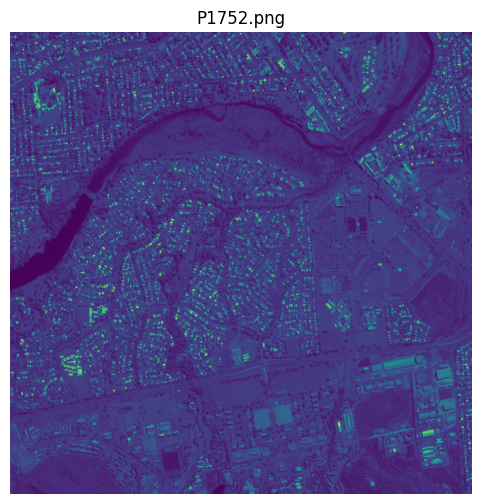

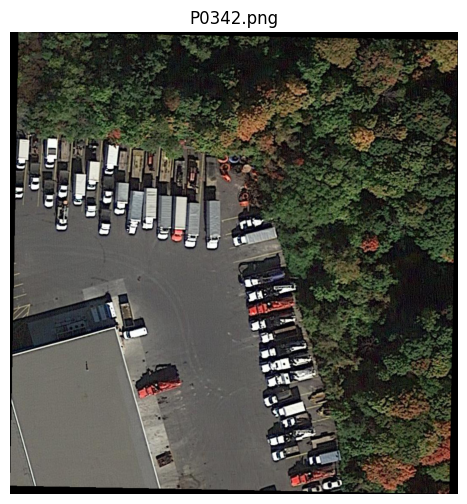

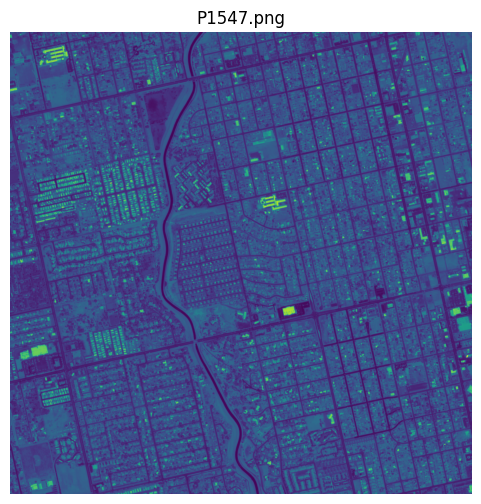

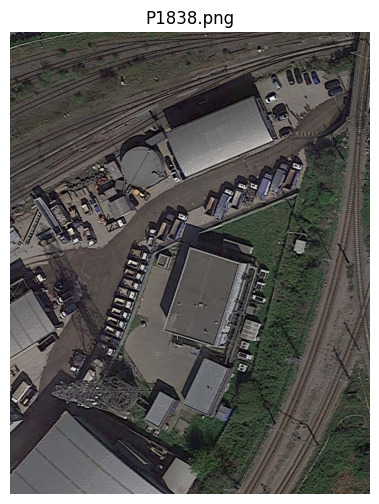

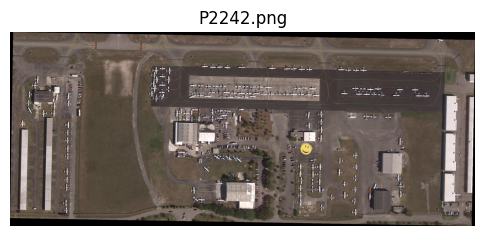

In [ ]:

# Path to training images
train_img_dir = "/content/drive/MyDrive/Datasets/DOTA/train/images"

# List first 5 images
sample_imgs = os.listdir(train_img_dir)[:5]
print("First 5 training images:", sample_imgs)

# Show them
for img_file in sample_imgs:
    img_path = os.path.join(train_img_dir, img_file)
    img = Image.open(img_path)

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(img_file)
    plt.show()


## Preprocessing Step
1. **Load data:** reads images and polygon labels.  
2. **Split sets:** splits train into **train (80%)** and **val (20%)**; official val used as **test**.  
3. **Convert labels:** polygons → bounding boxes, saved as:  
   - **YOLO TXT** required for YOLOv8 training.  
     - Saved in `train/labels/`, `val/labels/`, `test/labels/`  
     - Each line: `class_id x_center y_center width height` (normalized to [0,1]).  
4. **Organize folders:** copies images/labels into `train/`, `val/`, `test/`.  




In [ ]:
%cd /content/drive/MyDrive/ML_projects/object-detection/src
!python preprocessing.py

100%|██████████| 12/12 [00:01<00:00,  7.42it/s]


✅ Preprocessing complete. Dataset saved at /content/drive/MyDrive/Datasets/DOTA_coco



## Training YOLOv8

We train a **YOLOv8n (nano)** model on the preprocessed DOTA dataset:

- Uses `data.yaml` to load train/val/test splits.  
- Trains for 50 epochs (demo run), image size = 640, batch size = 8.  
- Results and weights are saved in: /content/drive/MyDrive/ML_projects/object-detection/runs/yolov8_dota/


Inside this folder:
- `weights/last.pt` → model weights after final epoch  
- `weights/best.pt` → best model (highest mAP on validation set)  
- `results.csv` and plots → training curves, metrics, and logs  


In [ ]:

from ultralytics import YOLO

model = YOLO("yolov8n.pt")  # start with nano model
model.train(
    data="/content/drive/MyDrive/Datasets/DOTA_coco/data.yaml",
    epochs=100,
    imgsz=640,
    batch=8,
    workers=2,
    project="/content/drive/MyDrive/ML_projects/object-detection/runs",
    name="yolov8_dota"
)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 36.7 MB/s eta 0:00:00



## Evaluate Trained Model on Test Set

We evaluate the trained YOLOv8 model on the **test split** to measure performance.  
This step computes key detection metrics:

- **Precision (P)** → how accurate the detections are  
- **Recall (R)** → how many true objects are found  
- **mAP@50 / mAP@50–95** → overall detection accuracy across IoU thresholds  



Saved outputs include:
- `confusion_matrix.png` → class-level errors  
- `BoxF1_curve.png`, `BoxP_curve.png`, `BoxR_curve.png` → precision/recall curves  
- `val_batch*_labels.jpg` & `val_batch*_pred.jpg` → sample ground-truth vs predictions  






In [ ]:
results = model.val(
    data="/content/drive/MyDrive/Datasets/DOTA_coco/data.yaml",
    split="test",   # tells YOLO to use test/images + test/labels
    imgsz=640,
    batch=8,
    workers=2,
    project="/content/drive/MyDrive/ML_projects/object-detection/runs",
    name="yolov8_dota_test_eval"
)

Ultralytics 8.3.202 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.4±0.2 ms, read: 9.9±12.5 MB/s, size: 11766.7 KB)
val: Scanning /content/drive/MyDrive/Datasets/DOTA_coco/test/labels... 12 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 12/12 5.2it/s 2.3s
val: New cache created: /content/drive/MyDrive/Datasets/DOTA_coco/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 0.8it/s 2.7s
                   all         12        805      0.518      0.324       0.19     0.0792
                  ship          2         72     0.0393     0.0833     0.0117     0.0066
      baseball-diamond          1          3          1          0     0.0182    0.00728
    ground-track-field          1          1      0.192          1      0.199      0.114
                harbor          2         81      0.269      0.037     0.0438     0.0122
         large-vehicle          5  

## Display some test results

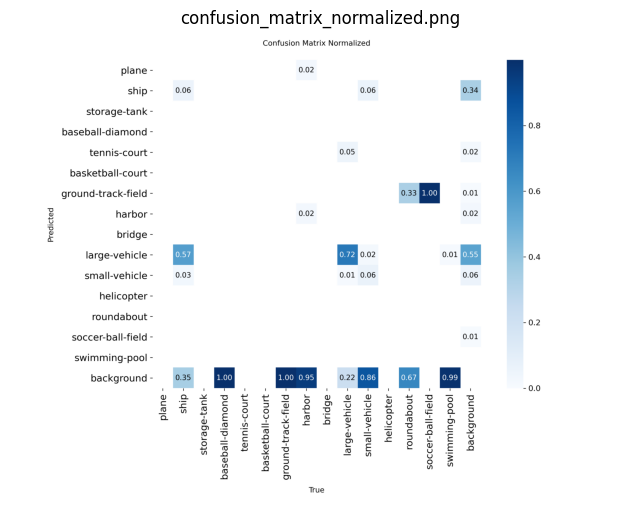

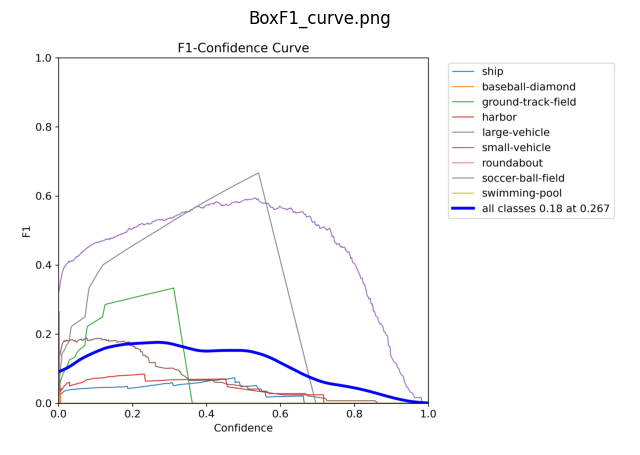

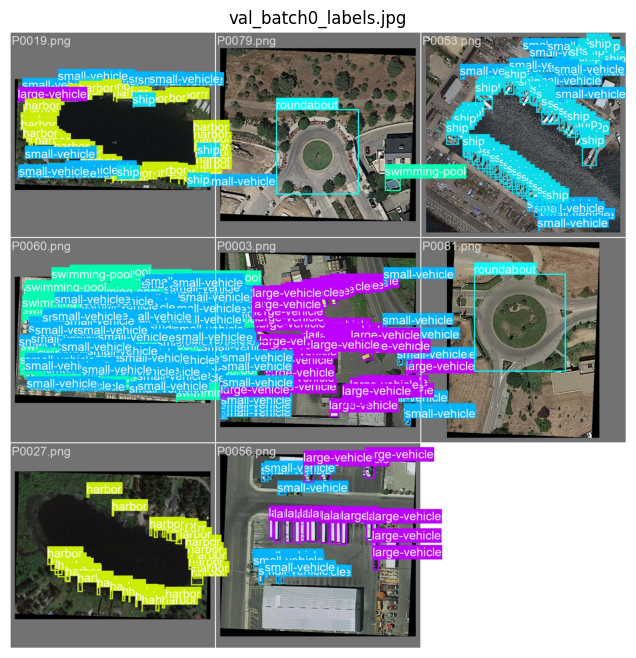

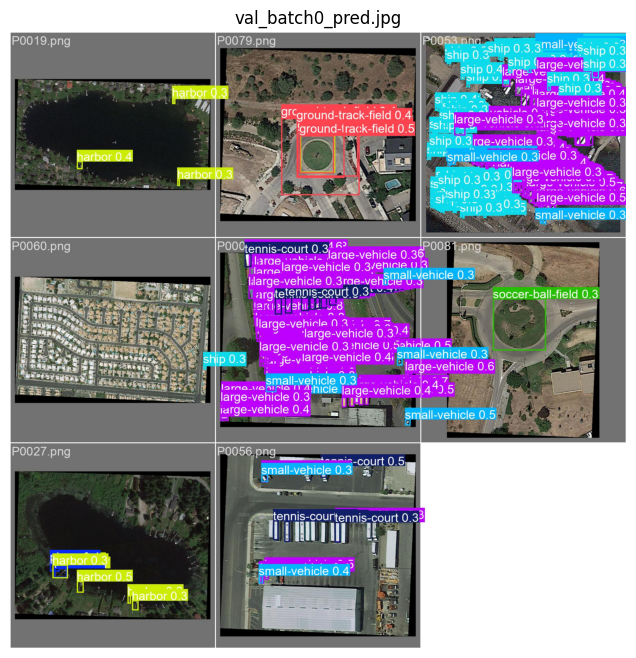

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Path to evaluation results (update if needed)
eval_dir = "/content/drive/MyDrive/ML_projects/object-detection/runs/yolov8_dota_test_eval"

# Files you want to display
files_to_show = [
    "confusion_matrix_normalized.png",
    "BoxF1_curve.png",
    "val_batch0_labels.jpg",
    "val_batch0_pred.jpg"
]

# Display images
for fname in files_to_show:
    fpath = os.path.join(eval_dir, fname)
    if os.path.exists(fpath):
        img = Image.open(fpath)
        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        plt.axis("off")
        plt.title(fname)
        plt.show()
    else:
        print(f"⚠️ File not found: {fpath}")

## Predict on the test set without ground truth annotation

In [ ]:

# Load trained weights
model = YOLO("/content/drive/MyDrive/ML_projects/object-detection/runs/yolov8_dota/weights/best.pt")

# Run prediction on test images
results = model.predict(
    source="/content/drive/MyDrive/Datasets/DOTA_coco/test/images",  # test images
    imgsz=640,
    batch=8,
    workers=2,
    project="/content/drive/MyDrive/ML_projects/object-detection/runs",
    name="yolov8_dota_test_pred",
    save=True,       # saves annotated images
    save_txt=True,   # saves YOLO txt results with confidences
    save_conf=True   # include confidence scores in txt
)



image 1/12 /content/drive/MyDrive/Datasets/DOTA_coco/test/images/P0003.png: 640x640 1 harbor, 81 large-vehicles, 2 small-vehicles, 5.2ms
image 2/12 /content/drive/MyDrive/Datasets/DOTA_coco/test/images/P0004.png: 640x640 127 large-vehicles, 16 small-vehicles, 5.2ms
image 3/12 /content/drive/MyDrive/Datasets/DOTA_coco/test/images/P0007.png: 640x640 13 ships, 173 large-vehicles, 14 small-vehicles, 5.2ms
image 4/12 /content/drive/MyDrive/Datasets/DOTA_coco/test/images/P0019.png: 640x640 3 harbors, 5.2ms
image 5/12 /content/drive/MyDrive/Datasets/DOTA_coco/test/images/P0027.png: 640x640 5 harbors, 5.2ms
image 6/12 /content/drive/MyDrive/Datasets/DOTA_coco/test/images/P0047.png: 640x640 1 ship, 1 ground-track-field, 1 soccer-ball-field, 5.2ms
image 7/12 /content/drive/MyDrive/Datasets/DOTA_coco/test/images/P0053.png: 640x640 116 ships, 54 large-vehicles, 9 small-vehicles, 5.2ms
image 8/12 /content/drive/MyDrive/Datasets/DOTA_coco/test/images/P0056.png: 640x640 1 ship, 6 tennis-courts, 1 ha